# 당뇨병 데이터셋 분류 분석

다음 5가지 알고리즘을 사용하여 당뇨병 데이터셋을 분석합니다:
1. 로지스틱 회귀(Logistic Regression)
2. 서포트 벡터 머신(SVM)
3. 의사결정 트리(Decision Tree)
4. 랜덤 포레스트(Random Forest)
5. K-최근접 이웃(KNN)

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# 그래프 스타일 설정
plt.style.use('ggplot')
sns.set(font_scale=1.2)
%matplotlib inline

## 1. 데이터셋 로드

In [2]:
# GitHub에서 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/diabetes.csv"
data = pd.read_csv(url)

# 데이터 형태 확인
print(f"데이터셋 크기: {data.shape}")
print("\n처음 5개 행:")
data.head()

데이터셋 크기: (768, 9)

처음 5개 행:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. 데이터 탐색

In [3]:
# 기술 통계량 확인
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
# 결측치 확인
print("결측치 확인:")
data.isnull().sum()

결측치 확인:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
# 타겟 변수 분포 확인
print("타겟 변수(Outcome) 분포:")
data['Outcome'].value_counts()

타겟 변수(Outcome) 분포:


Outcome
0    500
1    268
Name: count, dtype: int64

## 3. 데이터 시각화

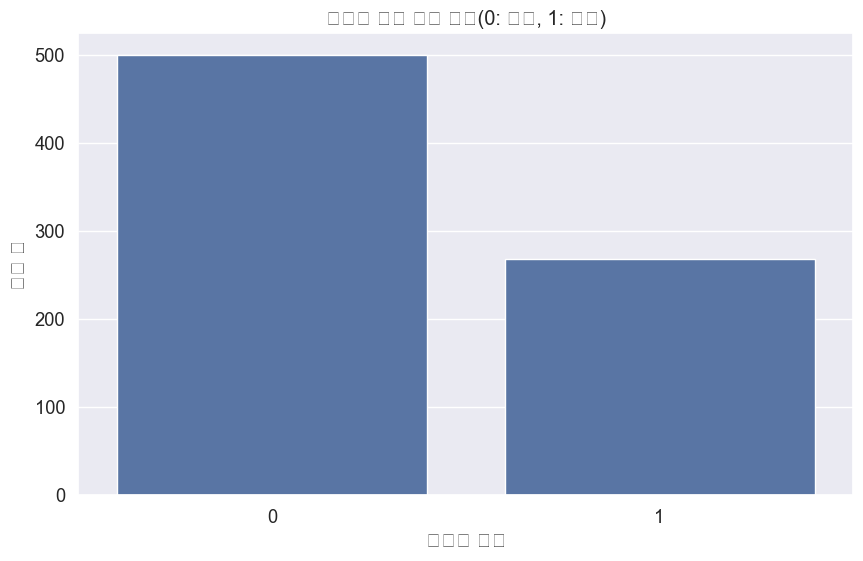

In [6]:
# 결과 변수 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='Outcome', data=data)
plt.title('당뇨병 진단 결과 분포(0: 음성, 1: 양성)')
plt.xlabel('당뇨병 진단')
plt.ylabel('환자 수')
plt.show()

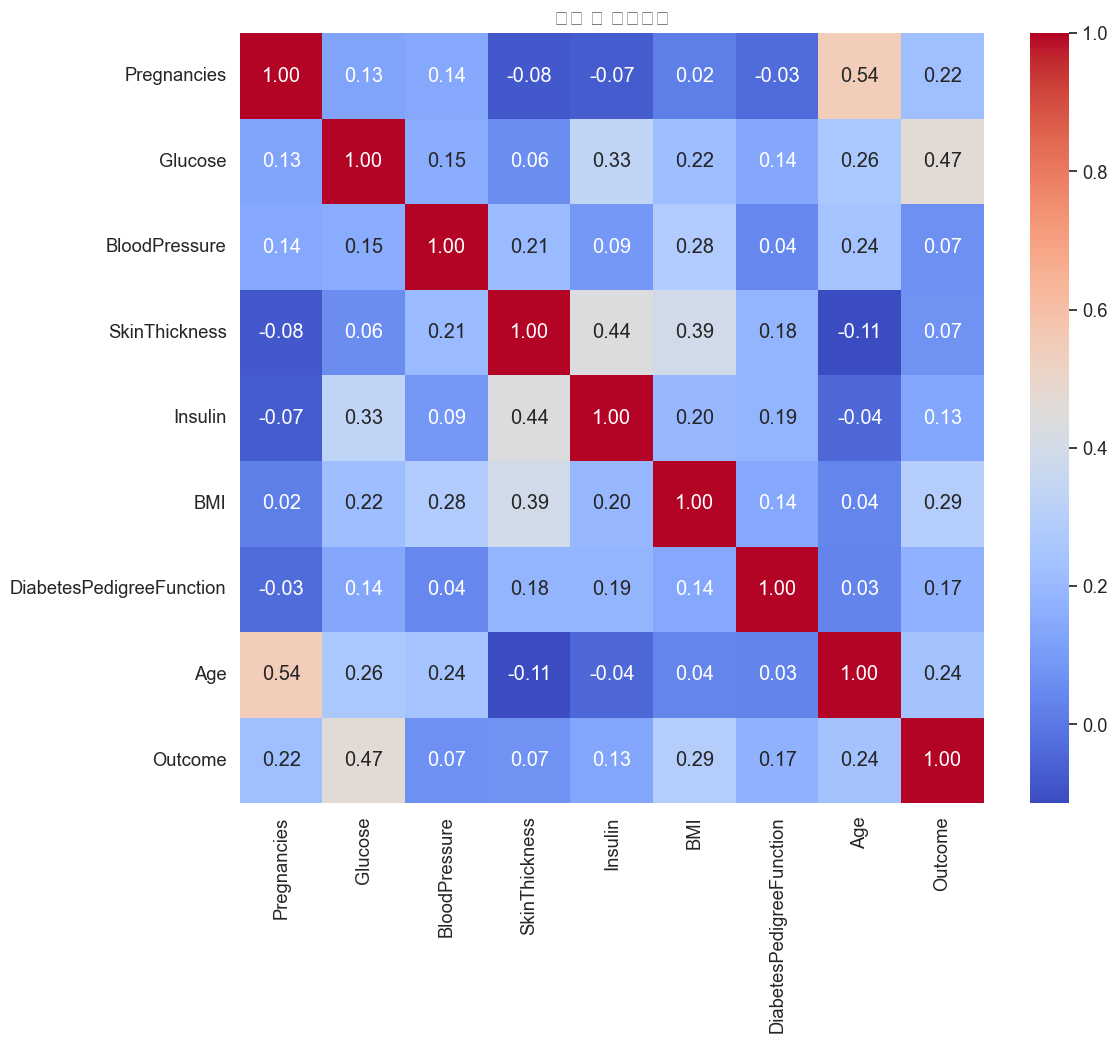

In [7]:
# 상관관계 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('변수 간 상관관계')
plt.show()

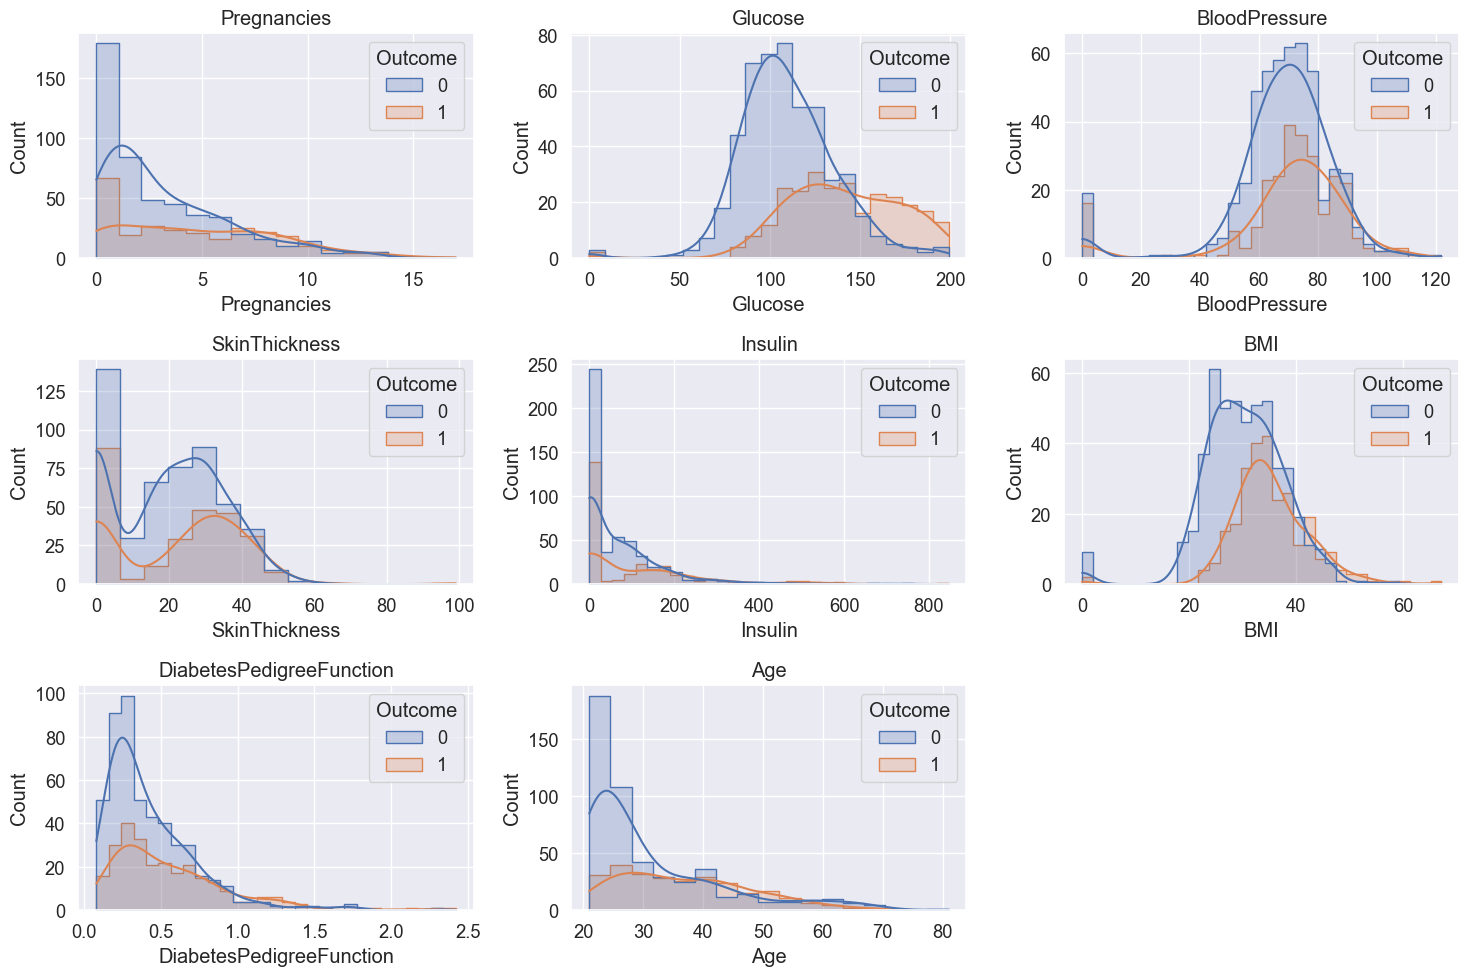

In [8]:
# 변수 분포 확인
plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=data, x=col, hue='Outcome', kde=True, element='step')
    plt.title(col)
plt.tight_layout()
plt.show()

## 4. 데이터 준비

In [9]:
# 특성과 타겟 변수 분리
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"학습 데이터 형태: {X_train.shape}")
print(f"테스트 데이터 형태: {X_test.shape}")

학습 데이터 형태: (614, 8)
테스트 데이터 형태: (154, 8)


## 5. 모델 학습 및 평가 함수 정의

In [10]:
# 모델 평가 함수 정의
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    
    # 정확도 계산
    accuracy = accuracy_score(y_test, y_pred)
    
    # 교차 검증
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # 결과 출력
    print(f"\n{model_name} 결과:")
    print(f"정확도: {accuracy:.4f}")
    print(f"교차 검증 점수: {cv_scores}")
    print(f"평균 교차 검증 점수: {np.mean(cv_scores):.4f}")
    
    # 분류 보고서 출력
    print("\n분류 보고서:")
    print(classification_report(y_test, y_pred))
    
    # 혼동 행렬 생성
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'혼동 행렬 - {model_name}')
    plt.ylabel('실제 값')
    plt.xlabel('예측 값')
    plt.show()
    
    # ROC 곡선 생성 (predict_proba를 지원하는 모델)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC 곡선 (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('위양성률(False Positive Rate)')
        plt.ylabel('진양성률(True Positive Rate)')
        plt.title(f'ROC 곡선 - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    except:
        print(f"{model_name}에 대한 ROC 곡선을 생성할 수 없습니다.")
    
    return accuracy, np.mean(cv_scores)

## 6. 로지스틱 회귀(Logistic Regression)


로지스틱 회귀 결과:
정확도: 0.7532
교차 검증 점수: [0.74796748 0.80487805 0.73170732 0.73170732 0.78688525]
평균 교차 검증 점수: 0.7606

분류 보고서:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



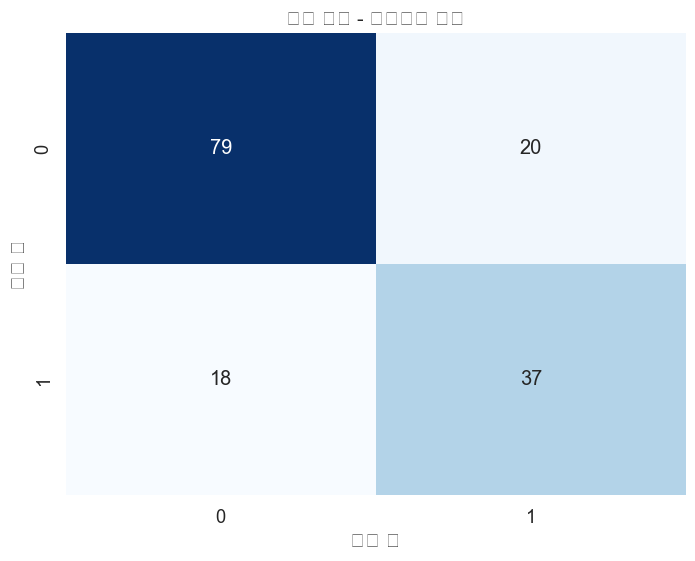

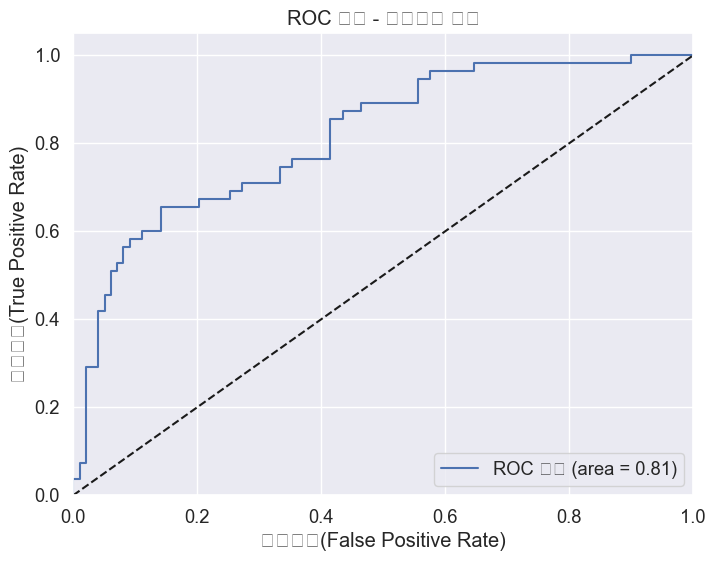

In [11]:
# 로지스틱 회귀 모델 생성 및 평가
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_accuracy, lr_cv_score = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "로지스틱 회귀")

## 7. 서포트 벡터 머신(SVM)


SVM 결과:
정확도: 0.7338
교차 검증 점수: [0.77235772 0.80487805 0.73170732 0.75609756 0.77868852]
평균 교차 검증 점수: 0.7687

분류 보고서:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        99
           1       0.65      0.56      0.60        55

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



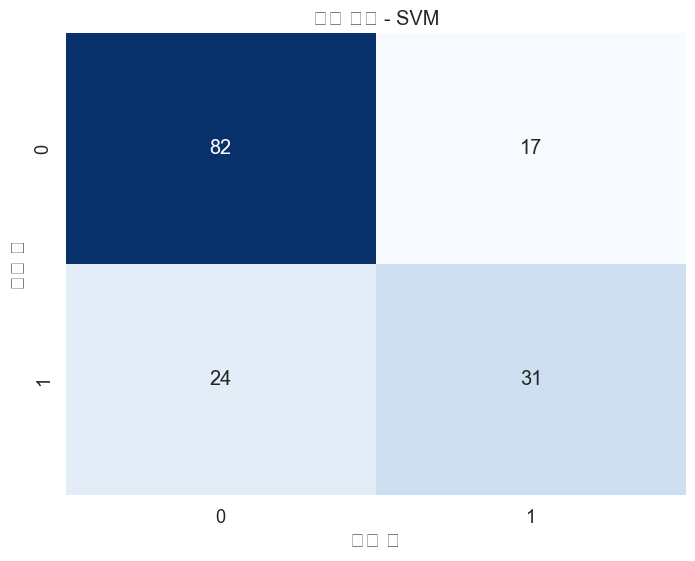

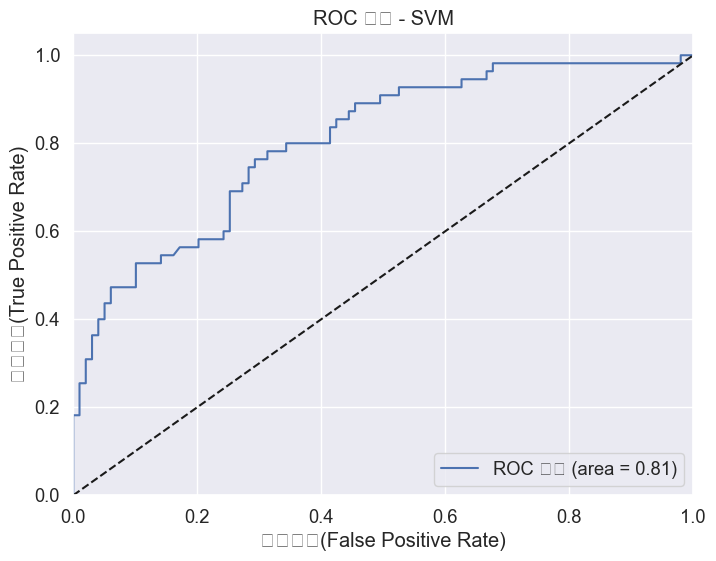

In [12]:
# SVM 모델 생성 및 평가
svm_model = SVC(probability=True, random_state=42)
svm_accuracy, svm_cv_score = evaluate_model(svm_model, X_train_scaled, X_test_scaled, y_train, y_test, "SVM")

## 8. 의사결정 트리(Decision Tree)


의사결정 트리 결과:
정확도: 0.7468
교차 검증 점수: [0.7398374  0.77235772 0.62601626 0.75609756 0.70491803]
평균 교차 검증 점수: 0.7198

분류 보고서:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        99
           1       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



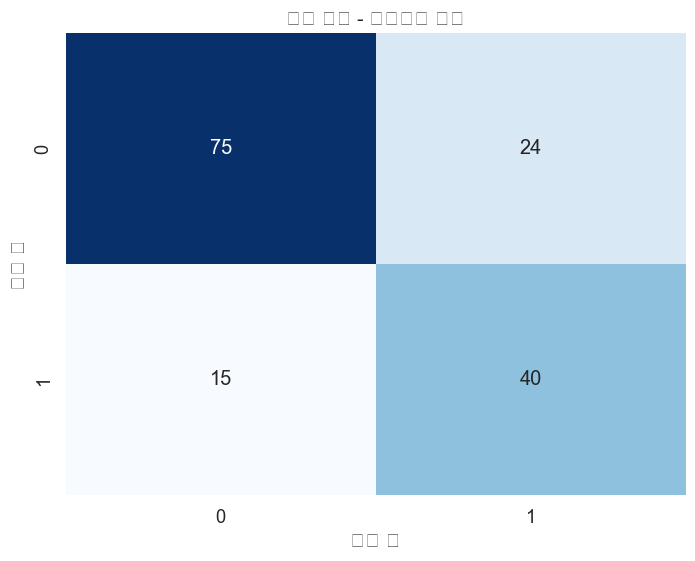

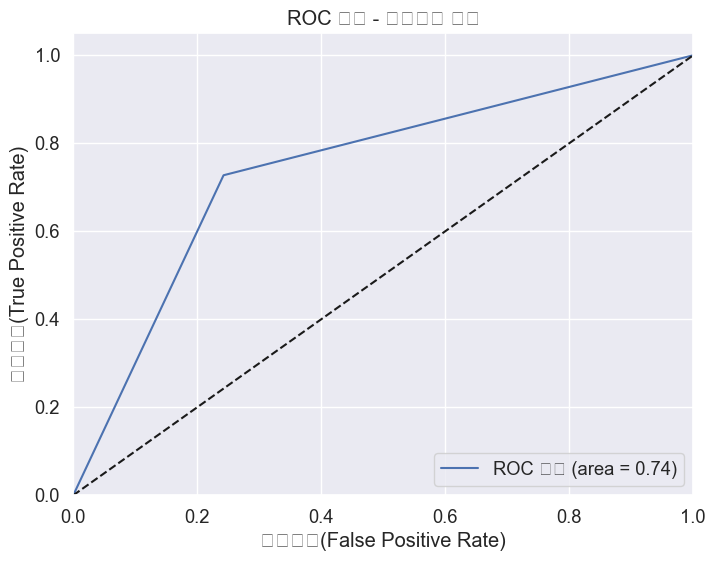

In [13]:
# 의사결정 트리 모델 생성 및 평가
dt_model = DecisionTreeClassifier(random_state=42)
dt_accuracy, dt_cv_score = evaluate_model(dt_model, X_train_scaled, X_test_scaled, y_train, y_test, "의사결정 트리")

## 9. 랜덤 포레스트(Random Forest)


랜덤 포레스트 결과:
정확도: 0.7208
교차 검증 점수: [0.78861789 0.80487805 0.72357724 0.74796748 0.81147541]
평균 교차 검증 점수: 0.7753

분류 보고서:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154



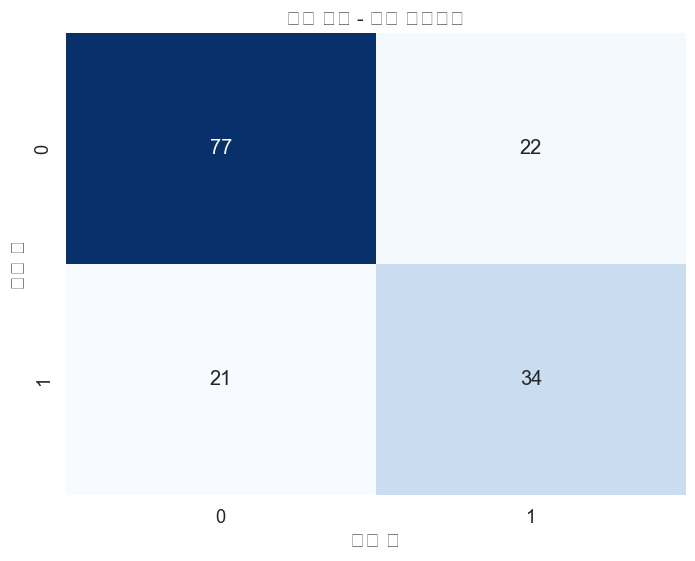

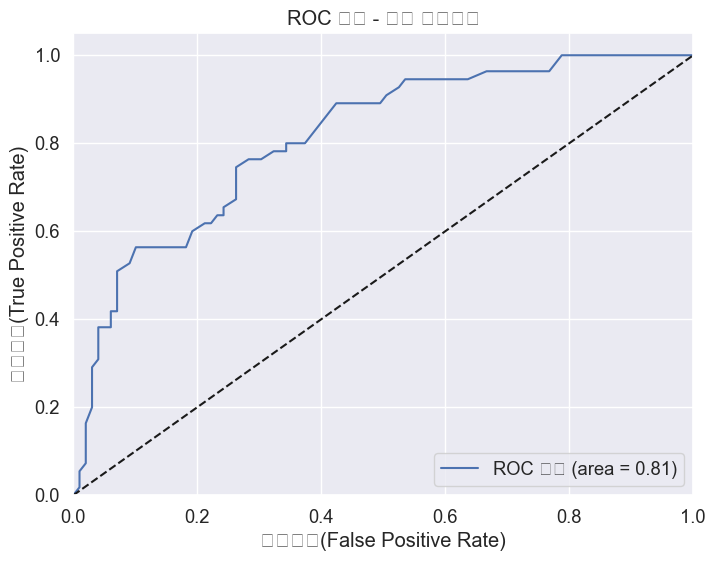

In [14]:
# 랜덤 포레스트 모델 생성 및 평가
rf_model = RandomForestClassifier(random_state=42)
rf_accuracy, rf_cv_score = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "랜덤 포레스트")

## 10. K-최근접 이웃(KNN)


KNN 결과:
정확도: 0.6948
교차 검증 점수: [0.69918699 0.77235772 0.73170732 0.7398374  0.77868852]
평균 교차 검증 점수: 0.7444

분류 보고서:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        99
           1       0.58      0.51      0.54        55

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.66       154
weighted avg       0.69      0.69      0.69       154



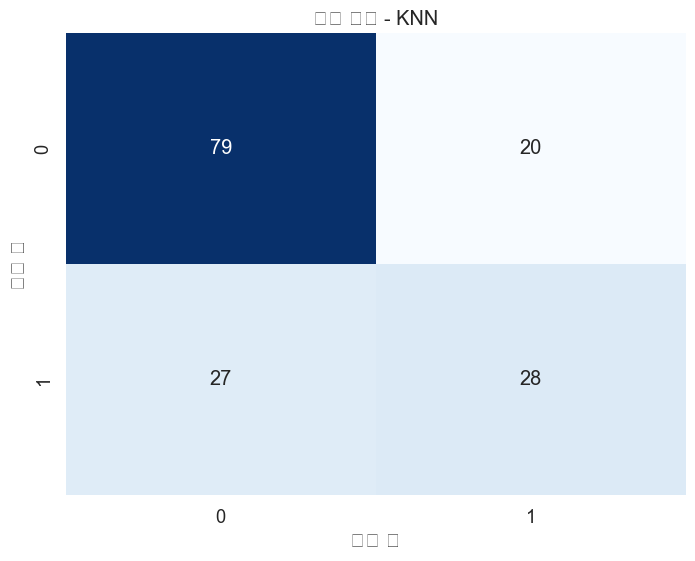

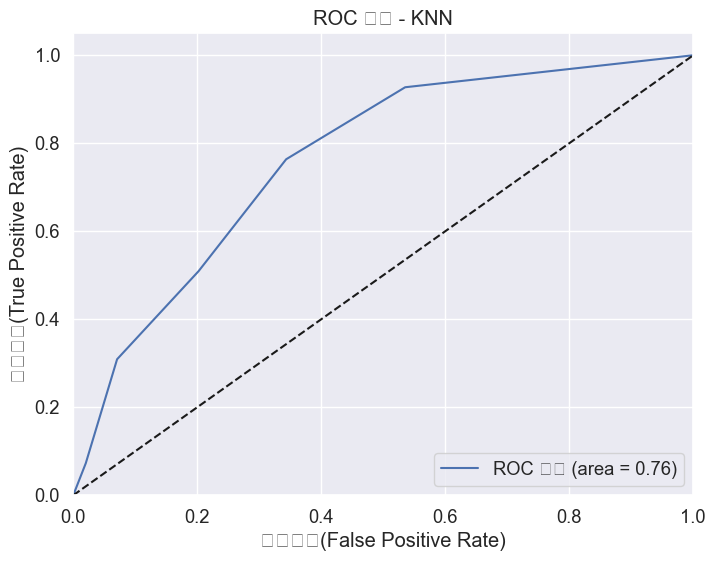

In [15]:
# KNN 모델 생성 및 평가
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_accuracy, knn_cv_score = evaluate_model(knn_model, X_train_scaled, X_test_scaled, y_train, y_test, "KNN")

## 11. 모델 성능 비교

In [16]:
# 모델 성능 비교
results = {
    "로지스틱 회귀": {'정확도': lr_accuracy, '교차 검증 점수': lr_cv_score},
    "SVM": {'정확도': svm_accuracy, '교차 검증 점수': svm_cv_score},
    "의사결정 트리": {'정확도': dt_accuracy, '교차 검증 점수': dt_cv_score},
    "랜덤 포레스트": {'정확도': rf_accuracy, '교차 검증 점수': rf_cv_score},
    "KNN": {'정확도': knn_accuracy, '교차 검증 점수': knn_cv_score}
}

results_df = pd.DataFrame(results).T
print("모델 성능 비교:")
results_df

모델 성능 비교:


,정확도,교차 검증 점수
로지스틱 회귀,0.753247,0.760629
SVM,0.733766,0.768746
의사결정 트리,0.746753,0.719845
랜덤 포레스트,0.720779,0.775303
KNN,0.694805,0.744356


<Figure size 1200x600 with 0 Axes>

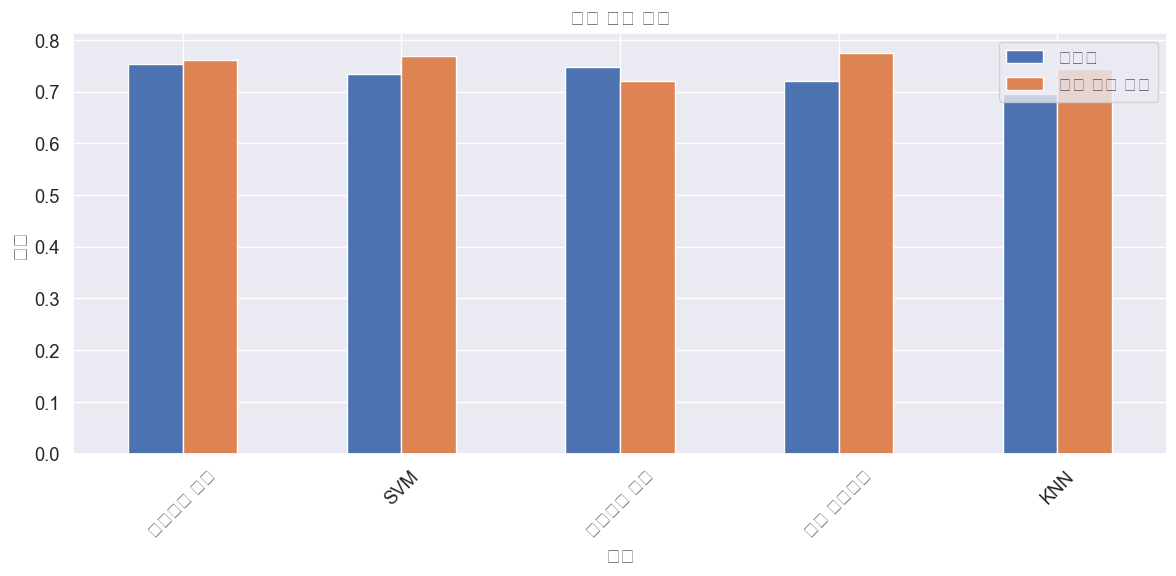

In [17]:
# 성능 비교 시각화
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('모델 성능 비교')
plt.ylabel('점수')
plt.xlabel('모델')
plt.xticks(rotation=45)
plt.legend(title='')
plt.tight_layout()
plt.show()

## 12. 특성 중요도 분석 (트리 기반 모델)

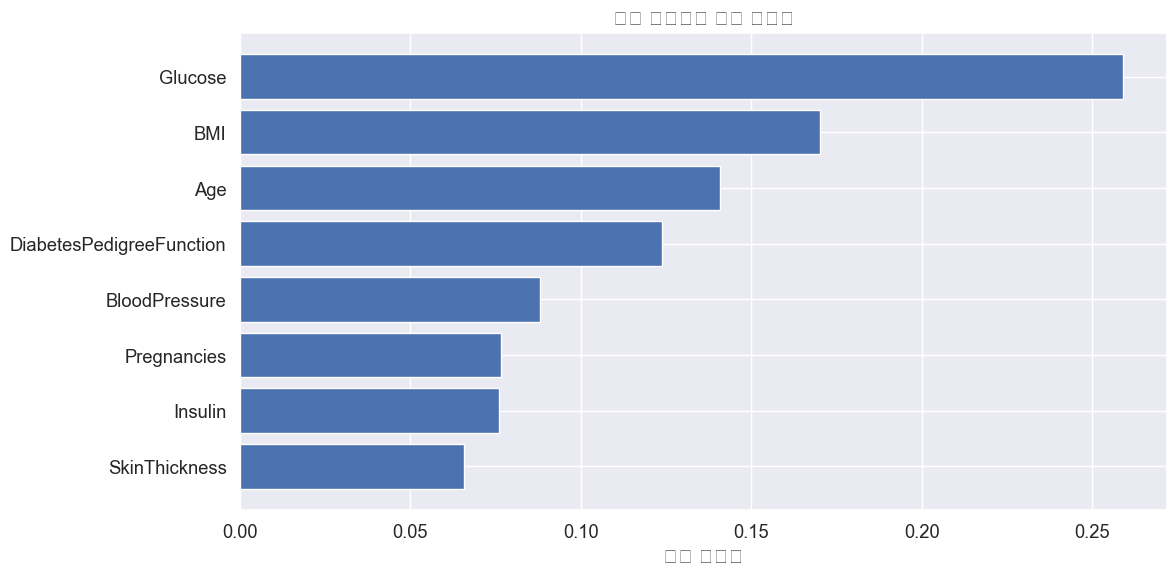

In [18]:
# 랜덤 포레스트 특성 중요도 시각화
plt.figure(figsize=(12, 6))
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('특성 중요도')
plt.title('랜덤 포레스트 특성 중요도')
plt.tight_layout()
plt.show()